pnevmoniya.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracted files to /content/pnevmoniya/
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 113s 772ms/step - accuracy: 0.7223 - loss: 0.6340 - val_accuracy: 0.7432 - val_loss: 0.4972
Epoch 2/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.8438 - loss: 0.3822

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8438 - loss: 0.3822 - val_accuracy: 0.7895 - val_loss: 0.4324
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 101s 751ms/step - accuracy: 0.7557 - loss: 0.4762 - val_accuracy: 0.7666 - val_loss: 0.4913
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4357 - val_accuracy: 0.7895 - val_loss: 0.4273
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 100s 738ms/step - accuracy: 0.7860 - loss: 0.4406 - val_accuracy: 0.7744 - val_loss: 0.4669
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.4233 - val_accuracy: 0.7368 - val_loss: 0.4665
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 98s 728ms/step - accuracy: 0.7976 - loss: 0.4198 - val_accuracy: 0.8027 - val_loss: 0.4354
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3274 - val_accuracy: 0.6842 - val_loss: 0.4587
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 99s 725ms/step - accuracy: 0.7787 - loss: 0.4407 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step
Submission file saved to /content/submission.csv


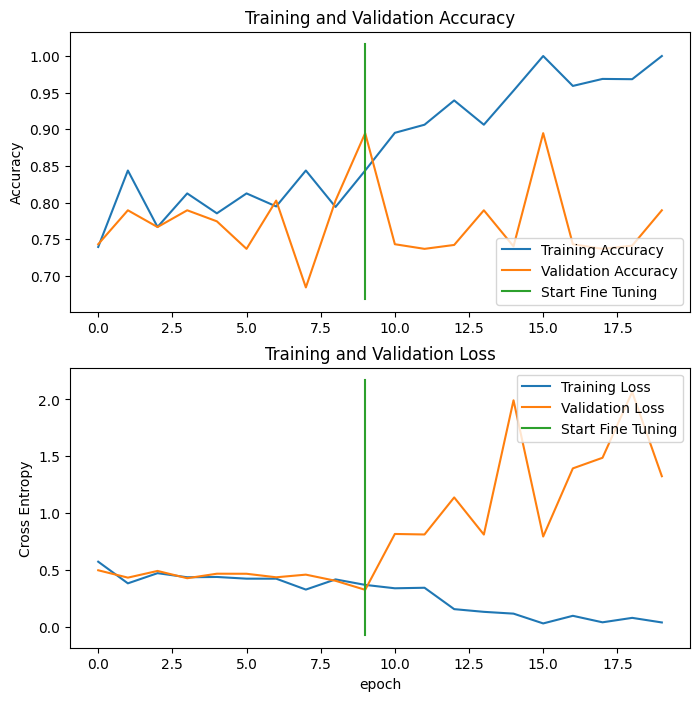

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1171: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


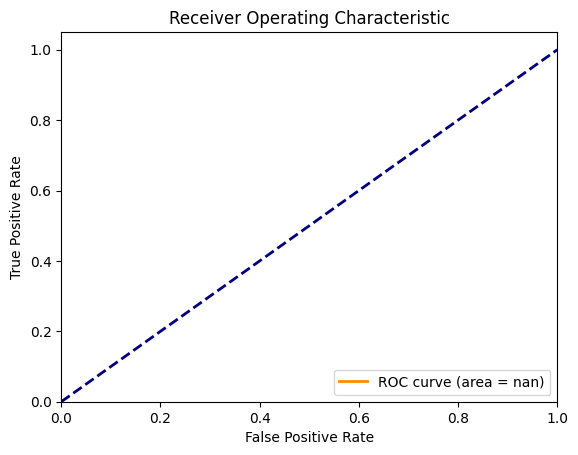

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       624

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



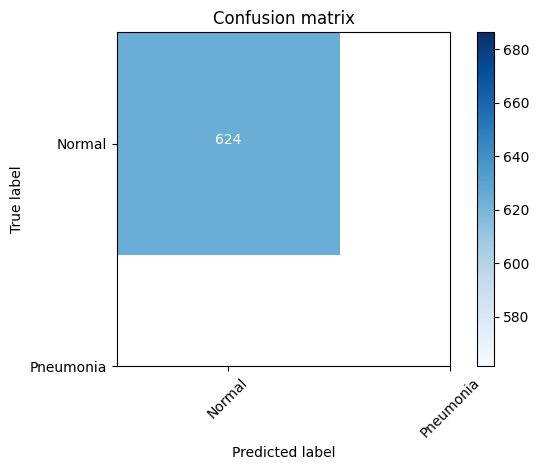

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import zipfile
import pandas as pd

# Kaggle setup (as in the original code)
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c pnevmoniya

zip_file_path = "/content/pnevmoniya.zip"
extract_to = "/content/pnevmoniya/"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted files to {extract_to}")

# Data directories
train_dir = "/content/pnevmoniya/train"
test_dir = "/content/pnevmoniya/test"
sample_solution_path = '/content/pnevmoniya/sample_solution.csv'

# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
EPOCHS = 10  # Reduced epochs for faster execution

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)

# Unfreeze base layers (Fine-tuning)
for layer in base_model.layers:
    layer.trainable = True

# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    initial_epoch=EPOCHS
)

# --- Improved test data handling and evaluation ---
test_df = pd.read_csv(sample_solution_path)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="id",
    y_col=None,  # No labels for test data
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None, # Important: class_mode=None for predictions
    shuffle=False # Important: shuffle=False to maintain prediction order
)

# Predictions on test data
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype("int32")

# Add predictions to the DataFrame
test_df['labels'] = predicted_classes

# Save the submission file
output_path = '/content/submission.csv'
test_df.to_csv(output_path, index=False)
print(f"Submission file saved to {output_path}")

# --- Visualization and evaluation ---

# Training history plots
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning') # Vertical line to mark fine-tuning start
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning') # Vertical line to mark fine-tuning start
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_df['labels'], predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification Report
print(classification_report(test_df['labels'], predicted_classes))

# Confusion Matrix
cm = confusion_matrix(test_df['labels'], predicted_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Pneumonia'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Pneumonia'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add values to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()